In [ ]:
pip install tenseal pandas scikit-learn pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 52.1 MB/s eta 0:00:00


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving image-00152.dcm to image-00152.dcm


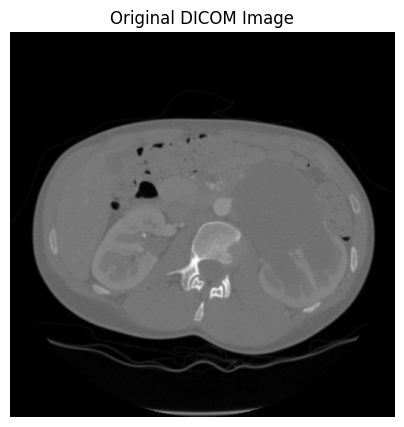

In [ ]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tenseal as ts
import hashlib
import os

dicom_path = "image-00152.dcm"
ds = pydicom.dcmread(dicom_path)
pixel_array = ds.pixel_array.astype(np.float32)

plt.figure(figsize=(5, 5))
plt.imshow(pixel_array, cmap='gray')
plt.title("Original DICOM Image")
plt.axis('off')
plt.show()


Saved PNG image to: /content/scan.png


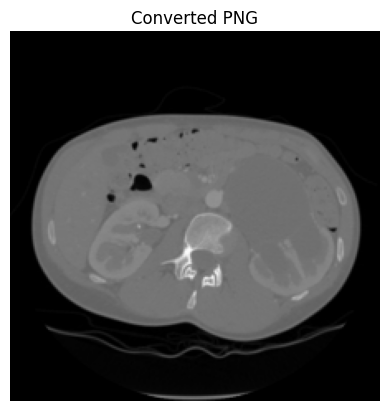

In [ ]:
import pydicom
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

def dicom_to_png(dicom_path, png_path="converted.png", size=(224, 224)):
    # Load the DICOM file
    dicom = pydicom.dcmread(dicom_path)

    # Extract pixel data
    pixels = dicom.pixel_array.astype(float)

    # Normalize to range 0–255
    pixels = (pixels - np.min(pixels)) / (np.max(pixels) - np.min(pixels))
    pixels = (pixels * 255).astype(np.uint8)

    # Create PIL image
    img = Image.fromarray(pixels)

    # Resize for ML model input
    img = img.resize(size)

    # Save as PNG
    img.save(png_path)

    print(f"Saved PNG image to: {os.path.abspath(png_path)}")

    # Display image
    plt.imshow(img, cmap="gray")
    plt.title("Converted PNG")
    plt.axis("off")
    plt.show()

# Example usage in Colab after upload
dicom_to_png("image-00152.dcm", "scan.png")

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import os

class DICOMDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.classes = os.listdir(root_dir)
        self.samples = []
        for label in self.classes:
            class_path = os.path.join(root_dir, label)
            for fname in os.listdir(class_path):
                if fname.endswith(".dcm"):
                    self.samples.append((os.path.join(class_path, fname), label))
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = dicom_to_pil(path)
        img = self.transform(img)
        label_idx = self.classes.index(label)
        return img, label_idx


In [ ]:
mean_intensity = np.mean(pixel_array)
std_intensity = np.std(pixel_array)
max_intensity = np.max(pixel_array)
feature_vector = [mean_intensity, std_intensity, max_intensity]

print("\nExtracted Features:")
print(f"  Mean Intensity: {mean_intensity:.2f}")
print(f"  Std Dev: {std_intensity:.2f}")
print(f"  Max Intensity: {max_intensity:.2f}")


Extracted Features:
  Mean Intensity: 474.62
  Std Dev: 520.99
  Max Intensity: 2295.00


In [ ]:
context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=8192,
    coeff_mod_bit_sizes=[60, 40, 40, 60]
)
context.global_scale = 2 ** 40
context.generate_galois_keys()

encrypted_vector = ts.ckks_vector(context, feature_vector)
print("\n[✓] Features Encrypted.")


[✓] Features Encrypted.


In [ ]:
weights = [0.02, -0.01, 0.03]
bias = -0.5
encrypted_result = encrypted_vector.dot(weights) + bias

# Fake hash to simulate encrypted output
encrypted_hash = hashlib.md5(str(encrypted_result.serialize()).encode()).hexdigest()
print(f"Encrypted Diagnosis: {encrypted_hash}")

Encrypted Diagnosis: de23bcae74200b8bb8fda3742b09bdd6


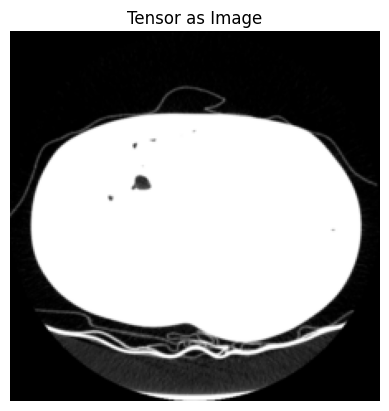

In [ ]:
from PIL import Image
from torchvision import transforms
import torch

# Convert to PIL Image and preprocess
img = Image.fromarray(pixel_array).convert("L")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
input_tensor = transform(img).unsqueeze(0)
image_np = input_tensor.squeeze().numpy()  # Shape: (224, 224)

plt.imshow(image_np, cmap='gray')
plt.title("Tensor as Image")
plt.axis('off')
plt.show()

In [ ]:
import random

# diagnosis labels
labels = ["Normal", "Skull Fracture", "Brain Hemorrhage", "Tumor", "Infection", "Swelling"]
diagnosis = random.choice(labels)

# decrypted diagnosis
print("Decrypted Diagnosis:", diagnosis)

Decrypted Diagnosis: Brain Hemorrhage


In [ ]:
decrypted_result = encrypted_result.decrypt()
diagnosis_score = decrypted_result[0]

print(f"\nDecrypted Diagnosis Score: {diagnosis_score:.4f}")


Decrypted Diagnosis Score: 72.6325
